In [1095]:
#
# Created on Fri Nov 24 2023 00:57:09
# Author: Mukai (Tom Notch) Yu
# Email: myual@connect.ust.hk
# Affiliation: Hong Kong University of Science and Technology
#
# Copyright Ⓒ 2023 Mukai (Tom Notch) Yu
#
import cv2
import numpy as np
import torch
import os
from abc import ABC, abstractmethod
from scipy.spatial.distance import cdist
from torch.utils.data import Dataset
from matplotlib import pyplot as plt

from utils.files import read_file, print_dict

In [1096]:
config = read_file("./configs/default.yaml")
print_dict(config)

train: 
  batch_size: 32.0
  epochs: 10.0
  learning_rate: 0.0001
  dataset: 
    COCO: 
      path: ./COCO2014/train2014
      fraction: 0.001
      resize: [640.0, 480.0]
      fix_warp: false
      shuffle: true
    ScanNet: 
      path: ./ScanNet/train
      fraction: 0.001
      resize: [640.0, 480.0]
      fix_warp: false
      shuffle: true
eval: 
  output_dir: ./dump_match_pairs/
  batch_size: 32.0
  eval_interval: 5.0
  dataset: 
    COCO: 
      path: ./COCO2014/eval2014
      fraction: 0.001
      resize: [640.0, 480.0]
      fix_warp: true
      shuffle: true
    ScanNet: 
      path: ./ScanNet/eval
      fraction: 0.001
      resize: [640.0, 480.0]
      fix_warp: true
      shuffle: true
superglue: 
  num_layers: 3.0
  sinkhorn_iterations: 10.0
  match_threshold: 0.2
  descriptor_dim: 256.0
feature_extraction: 
  max_keypoints: 64.0
  descriptor_dim: 256.0
  extractor: 
    SIFT: 
      contrast_threshold: 0.04
      edge_threshold: 10.0
      sigma: 1.6
perspective_warpe

In [1097]:
class FeatureExtractor(ABC):
    def __new__(cls, config):
        # Use __new__ to create an instance of the appropriate subclass
        extractor_config = config["extractor"]
        if extractor_config is None:
            raise ValueError("Missing extractor config")

        if "SIFT" in extractor_config:
            return super(FeatureExtractor, cls).__new__(SiftExtractor)
        elif "superpoint" in extractor_config:
            return super(FeatureExtractor, cls).__new__(SuperpointExtractor)
        else:
            raise ValueError(
                "Unsupported feature extractor type "
                + next(iter(extractor_config))
                + " in config"
            )

    def __init__(self, config):
        # This will only be called if a subclass instance is not created in __new__
        # Initialize shared configuration parameters
        self.config = config
        self.max_keypoints = int(config["max_keypoints"])
        self.descriptor_dim = int(config["descriptor_dim"])

    @abstractmethod
    def __call__(self, image):
        # This will be called when the instance is called like a function, e.g.
        # feature_extractor = FeatureExtractor(config["feature_extraction"])
        # features = feature_extractor(image)
        pass


class SiftExtractor(FeatureExtractor):
    def __init__(self, config):
        super().__init__(config)
        self.contrast_threshold = float(
            config["extractor"]["SIFT"]["contrast_threshold"]
        )
        self.edge_threshold = float(config["extractor"]["SIFT"]["edge_threshold"])
        self.sigma = float(config["extractor"]["SIFT"]["sigma"])
        self.sift = cv2.SIFT_create(nfeatures=self.max_keypoints)

    def __call__(self, image):
        keypoints, descriptors = self.sift.detectAndCompute(image, None)
        confidence_scores = torch.tensor([k.response for k in keypoints]).unsqueeze(-1)
        keypoints = torch.tensor([(kp.pt[0], kp.pt[1]) for kp in keypoints])
        descriptors = torch.tensor(descriptors)
        return keypoints, descriptors, confidence_scores


class SuperpointExtractor(FeatureExtractor):
    def __init__(self, config):
        super().__init__(config)
        self.superpoint = cv2.cuda_SuperPoint.create(
            config["extractor"]["superpoint"]["model"]
        )

    def __call__(self, image):
        image = cv2.UMat(image)
        keypoints, descriptors = self.superpoint(image)
        keypoints = keypoints.get
        descriptors = descriptors.get()
        if descriptors is None:
            descriptors = np.zeros((0, self.descriptor_dim))
        return np.array(keypoints), np.array(descriptors)

In [1098]:
class PerspectiveWarper(ABC):
    def __new__(cls, config):
        if config is None:
            raise ValueError("Missing perspective warper config")

        if "homography" in config:
            return super(PerspectiveWarper, cls).__new__(HomographyWarper)
        elif "nerf" in config:
            return super(PerspectiveWarper, cls).__new__(NerFWarper)
        else:
            raise ValueError(
                "Unsupported perspective warper type "
                + next(iter(config))
                + " in config"
            )

    def __init__(self, config):
        pass

    @abstractmethod
    def generate_transform(self, width, height):
        pass

    @abstractmethod
    def warp_image_to_novel(self, image, warp_transform):
        pass

    @abstractmethod
    def warp_keypoints_to_novel(self, keypoints, warp_transform):
        pass

    @abstractmethod
    def warp_keypoints_to_original(self, keypoints, warp_transform):
        pass


class HomographyWarper(PerspectiveWarper):
    def __init__(self, config):
        super().__init__(config)
        self.perturbation_threshold = float(
            config["homography"]["perturbation_threshold"]
        )

    def generate_transform(self, width, height):
        corners = np.float32([[0, 0], [0, height], [width, 0], [width, height]])
        # warp = np.random.randint(
        #     -width * self.perturbation_threshold,
        #     width * self.perturbation_threshold,
        #     size=(4, 2),
        # ).astype(np.float32)

        # Generate random perturbations for x (width) and y (height) separately
        warp_x = np.random.randint(
            -width * self.perturbation_threshold,
            width * self.perturbation_threshold,
            size=(4, 1),
        ).astype(np.float32)
        warp_y = np.random.randint(
            -height * self.perturbation_threshold,
            height * self.perturbation_threshold,
            size=(4, 1),
        ).astype(np.float32)
        warp = np.hstack((warp_x, warp_y))  # Combine x and y perturbations

        new_corners = corners + warp
        transform = cv2.getPerspectiveTransform(corners, new_corners)

        return [transform, (width, height)]

    def warp_image_to_novel(self, image, warp_transform):
        return cv2.warpPerspective(image, warp_transform[0], warp_transform[1])

    def warp_keypoints_to_novel(self, keypoints, warp_transform):
        pass

    def warp_keypoints_to_original(self, keypoints, warp_transform):
        pass


class NerFWarper(PerspectiveWarper):
    def __init__(self, config):
        super().__init__(config)
        self.novel_vew_max_angle = float(config["nerf"]["novel_view_max_angle"])

    def generate_transform(self, width, height):
        raise NotImplementedError

    def warp_image_to_novel(self, image, warp_transform):
        raise NotImplementedError

    def warp_keypoints_to_novel(self, keypoints, warp_transform):
        raise NotImplementedError

    def warp_keypoints_to_original(self, keypoints, warp_transform):
        raise NotImplementedError

In [1099]:
class COCODataset(Dataset):
    def __init__(self, config: dict, feature_extractor, perspective_warper):
        self.config = config
        self.path = config["path"]
        self.fraction = config["fraction"]
        self.resize = [int(dim) for dim in config["resize"]]
        self.fix_warp = config["fix_warp"]
        self.shuffle = config["shuffle"]

        self.feature_extractor = feature_extractor
        self.perspective_warper = perspective_warper

        self.files = []
        # recursively walk though the directory
        for root, _, files in os.walk(self.path):
            for file in files:
                if file.endswith(".jpg") or file.endswith(".png"):
                    self.files.append(os.path.join(root, file))

        # limit the number of files to self.fraction x total number of files
        self.files = self.files[: int(len(self.files) * self.fraction)]

        if self.fix_warp:
            self.transforms = [
                self.perspective_warper.generate_transform(*self.resize)
                for _ in range(len(self.files))
            ]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index: int):
        file = self.files[index]
        image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        if self.resize is not None:
            image = cv2.resize(image, self.resize)

        width, height = image.shape

        # Retrieve or generate transform
        transform = (
            self.transforms[index]
            if self.fix_warp
            else self.perspective_warper.generate_transform(width, height)
        )

        # Apply transform
        warped_image = self.perspective_warper.warp_image_to_novel(image, transform)

        (
            keypoints_original,
            descriptors_original,
            confidence_score_original,
        ) = self.feature_extractor(image)
        (
            keypoints_warped,
            descriptors_warped,
            confidence_score_warped,
        ) = self.feature_extractor(warped_image)
        plt.imshow(warped_image)
        plt.show()

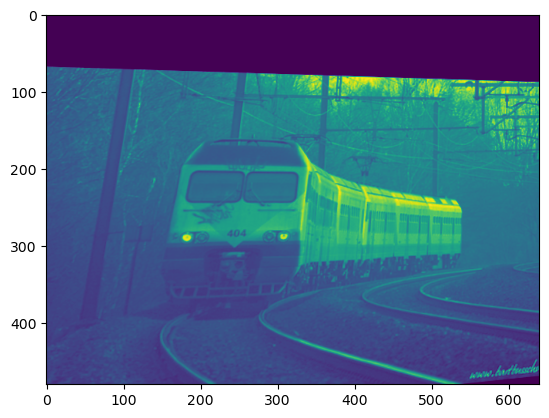

In [1100]:
feature_extractor = FeatureExtractor(config["feature_extraction"])
perspective_warper = PerspectiveWarper(config["perspective_warper"])

coco_training_dataset = COCODataset(
    config["train"]["dataset"]["COCO"], feature_extractor, perspective_warper
)
coco_training_dataset[0]